# Author: Jakob Adamsson
Built for a Machine learning project at Blekinge Tekniska Högskola, winter 2022

Task: Clean Twitter dataset and apply machinelearning models and evaluate them

Dataset: https://www.kaggle.com/datasets/kazanova/sentiment140?resource=download

Acronym: JAAD19

Program: DVAMI20h

In [2]:
# For model building
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import confusion_matrix as cm
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import f1_score as fs
from sklearn.naive_bayes import MultinomialNB
from scipy.stats import kruskal
import matplotlib.pyplot as plt
import numpy as np
import datacleaning as dc
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from sklearn.model_selection import learning_curve

# For data cleaning
import nltk as sw  # sw for stopwords
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import re

sw.download("stopwords")
sw.download("punkt")

[nltk_data] Downloading package stopwords to /home/jakob/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/jakob/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/jakob/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/jakob/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Clean the data
These are the steps i will use during data cleaning phase:
1. Analyze the data, find outliers and remove them also remove useless columns
2. See if there is a significant amount of unicode characters such as #, [], \n \r digits in words etc, if it is, replace them with ""(empty space)
3. Remove stop words, stop words does not usually have a weight when using NLP and i will use a lib for that
4. Apply a stemming algorithm on the dataset so that words that mean the same thing gets replaced by another more general word. Ex am, are, is $\Rightarrow$ be

#### Read the data into dataframe using Pandas

In [64]:

df = pd.read_csv("dataset/data.csv")
df = df[["text", "target"]]
df.loc[df["target"] == 4, "target"] = 1
df

,text,target
0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",0
1,is upset that he can't update his Facebook by ...,0
2,@Kenichan I dived many times for the ball. Man...,0
3,my whole body feels itchy and like its on fire,0
4,"@nationwideclass no, it's not behaving at all....",0
...,...,...
1599995,Just woke up. Having no school is the best fee...,1
1599996,TheWDB.com - Very cool to hear old Walt interv...,1
1599997,Are you ready for your MoJo Makeover? Ask me f...,1
1599998,Happy 38th Birthday to my boo of alll time!!! ...,1


In [65]:
def clean_text(df: pd.DataFrame, column: str) -> pd.DataFrame:
    df[column] = df[column].str.replace(r"@\w+", "")
    df[column] = df[column].str.replace(r"\d", "")
    df[column] = df[column].str.replace(r"\n", "")
    df[column] = df[column].str.replace(r"\[.*?\]", "")
    df[column] = df[column].str.replace(r"https?:\/\/.*[\r\n]*", "", case=False)
    df[column] = df[column].str.replace(r"#\w+", "", case=False)
    df[column] = df[column].apply(lambda x: re.sub(r"[^\w\s]", "", x))
    return df


def remove_stop_words(df: pd.DataFrame, column: str, language: str = "english") -> pd.DataFrame:
    """Remove stopwords from each tweet, since stopwords does not ususally have a large impact when training the model"""

    stop_words = stopwords.words(language)
    df[column] = df[column].apply(lambda x: " ".join([word for word in x.split() if word not in stop_words]))
    return df


def stem_tweets(df: pd.DataFrame, column: str) -> str:
    stemmer = PorterStemmer()
    df[column] = df[column].apply(lambda x: " ".join([stemmer.stem(word) for word in word_tokenize(x)]))
    return df


def getDataFrame(path: str) -> pd.DataFrame:
    df = pd.read_csv(path)
    df = df[["text", "target"]]

    # Remove tweets that occurs more than once
    df.drop_duplicates(subset=["text"])
    df = stem_tweets(df, "text")
    df = clean_text(df, "text")
    df = remove_stop_words(df, "text", "english")
    return df

#### Apply the methods on the dataset

In [66]:
# Remove tweets that occurs more than once
df.drop_duplicates(subset=["text"], inplace=True)

# Apply the methods
df = stem_tweets(df, "text")
df = clean_text(df, "text")
df = remove_stop_words(df, "text", "english")

/tmp/ipykernel_60082/732672620.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df[column] = df[column].str.replace(r"@\w+", "")
/tmp/ipykernel_60082/732672620.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  df[column] = df[column].str.replace(r"\d", "")
/tmp/ipykernel_60082/732672620.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  df[column] = df[column].str.replace(r"\n", "")
/tmp/ipykernel_60082/732672620.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  df[column] = df[column].str.replace(r"\[.*?\]", "")
/tmp/ipykernel_60082/732672620.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  df[column] = df[column].str.replace(r"https?:\/\/.*[\r\n]*", "", case=False)
/tmp/ipykernel_60082/732672620.py:7: FutureWarning: The default

Save the new dataframe

In [67]:
df.to_csv("data_updated.csv", index=False, header=True)

Use the new dataframe

#### Check if the data is balanced

In [68]:
df_1 = df[df["target"] == 1]
df_0 = df[df["target"] == 0]
print(f"Amount of tweets that are positive: {len(df_1)}\nAmount of tweets that are nagative: {len(df_0)}")

print(f"Positive tweets: {len(df_1)/(len(df_1) + len(df_0))}%\nNegative tweets: {len(df_0)/(len(df_1) + len(df_0))}%")

# LÄGG IN ÖVER
df.dropna(axis=0, inplace=True)

Amount of tweets that are positive: 791281
Amount of tweets that are nagative: 790185
Positive tweets: 0.5003465139307453%
Negative tweets: 0.49965348606925475%


We can see that the data is balanced, there is therefore no need to remove any values or anything like that

#### Lets remove words that are not above a certain frequency

In [69]:
def remove_low_freq_words(df, column, threshold):
    df.dropna(axis=0, inplace=True)
    vectorizer = TfidfVectorizer()
    vectorizer.fit(df[column])
    
    # Get the feature names
    feature_names = vectorizer.vocabulary_
    
    #
    tfidf = vectorizer.transform(df[column]).toarray()
    
    filtered_words = [[word for word, value in zip(feature_names, values) if value >= threshold] for values in tfidf]  
    
    filtered_text = [' '.join(words) for words in filtered_words]

    # Replace the text in the specified column with the filtered text
    df[column] = filtered_text

    return df  

In [1]:
# Split the data into chunks for faster processing
df_chuncks = pd.read_csv("dataset/data_updated.csv", chunksize=50000)
df_list = []
for chunck in df_chuncks:
    temp = remove_low_freq_words(chunck, "text", 0.3)
    df_list.append(temp)

df = pd.concat(df_list)


NameError: name 'pd' is not defined

Save the new dataframe due to it took 63 minutes for it to clean up. Load in the recently saved dataframe into df

In [71]:
df.to_csv("dataset/data_updated2.csv", index=False, header=True)

Load the newly created dataset

In [8]:
df = pd.read_csv("dataset/data_updated2.csv")
df.dropna(axis=0, inplace=True)

# Build the models
1. Pick a model
2. Build a model and evaluate
3. Repeat untill three models are done

Split the dataset into train and test sets, splitting at 1/5 of the whole dataset

In [9]:
X_train, X_test, Y_train, Y_test = train_test_split(df["text"], df["target"], test_size=0.2, random_state=42)

Vectorize and reshape the train and testdata(tokenize)

In [10]:
    # See the distribution of the data
    print(Y_train.value_counts())
    
    # Vectorize the train and test data
    vectorizer = TfidfVectorizer()
    X_train = vectorizer.fit_transform(X_train)
    X_test = vectorizer.transform(X_test)

    # Ensure that all train and test data has the same shape
    X_train = np.reshape(X_train, (len(Y_train), X_test.shape[1]))
    X_test = np.reshape(X_test, (len(Y_test), X_test.shape[1]))

1    631865
0    631848
Name: target, dtype: int64


## Building the models

In [11]:
class PredictDisaster:
    def __init__(self, algorithm, X_train, Y_train, X_test, Y_test, name):
        self.algorithm = algorithm
        print(f"Training started...({name})")
        self.fit_data(X_train, Y_train)
        print(f"Training finished...({name})")
        self.pred = self.predict_data(X_test)
        print(f"Prediction finished...({name})")
        self.acc = self.acc_score(Y_test)
        print(f"Accuracy score calculated...({name})")
        self.cm = self.conf_mat(Y_test)
        print(f"Confusion matrix calculated...({name})")
        self.fs = self.f1_score(Y_test)
        print(f"F1 score calculated...({name})\n")
    
    def fit_data(self,X_train, Y_train):
        self.algorithm.fit(X_train, Y_train)
        
    def predict_data(self, X_test):
        return self.algorithm.predict(X_test)
    
    def acc_score(self, Y_test):
        return accuracy_score(Y_test, self.pred)
    
    def conf_mat(self, Y_test):
        return cm(Y_test, self.pred)
    
    def f1_score(self, Y_test):
        return fs(Y_test, self.pred)
    
    def print_methods(self):
        print("""
              1. fit_data(X_train, Y_train)
              2. predict_data(X_test)
              3. acc_score(Y_test)
              4. conf_mat(Y_test)
              5. f1_score(Y_test)
              """)
    

# Predict the disaster
lr_C = PredictDisaster(LogisticRegression(solver="sag", max_iter=100000), X_train, Y_train, X_test, Y_test, "LogisticRegression")
gbc_C = PredictDisaster(GradientBoostingClassifier(), X_train, Y_train, X_test, Y_test, "GradientBoostingClassifier")
svm_C = PredictDisaster(SGDClassifier(loss="hinge"), X_train, Y_train, X_test, Y_test, "SVM")
mnb_C = PredictDisaster(MultinomialNB(), X_train, Y_train, X_test, Y_test, "MultinomialNB")

Training started...(LogisticRegression)
Training finished...(LogisticRegression)
Prediction finished...(LogisticRegression)
Accuracy score calculated...(LogisticRegression)
Confusion matrix calculated...(LogisticRegression)
F1 score calculated...(LogisticRegression)

Training started...(GradientBoostingClassifier)


KeyboardInterrupt: 

#### Pickle the models, saved models are located in "pickled_models"

In [49]:
model_list = [lr_C, gbc_C, svm_C, mnb_C]
model_list_names = ["LogisticRegression", "GradientBoostingClassifier", "SVM", "MultinomialNB"]
for i in range(len(model_list)):
    with open(f"pickled_models/{model_list_names[i]}.pickle", "wb") as f:
        pickle.dump(model_list[i], f)

#### Print the accuracy score

In [11]:
print(f"Logistic Regression accuracy score: {lr_C.acc}\nGradient Boosting Classifier accuracy score: {gbc_C.acc}\nSVM accuracy score: {svm_C.acc}\nMultinomialNB accuracy score: {mnb_C.acc}")

Logistic Regression accuracy score: 0.9352671011524741
Gradient Boosting Classifier accuracy score: 0.5365984129345518
SVM accuracy score: 0.8434046890282311
MultinomialNB accuracy score: 0.9473141117149739


#### Plot of Logistic Regression Confusion Matrix

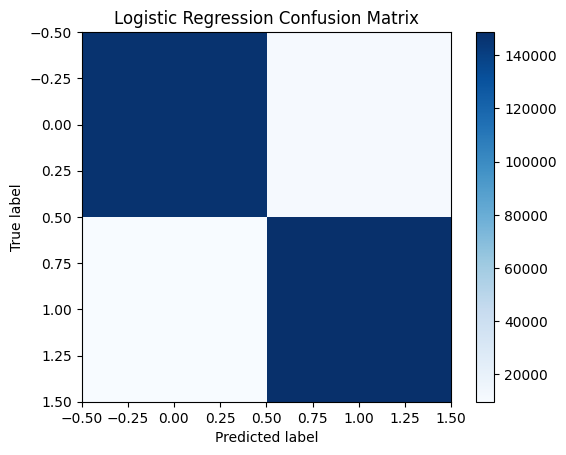

[[146752  10777]
 [  9674 148726]]


In [44]:

plt.imshow(lr_C.cm, cmap='Blues')
plt.colorbar()
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Logistic Regression Confusion Matrix")
plt.show()
print(f"{lr_C.cm}")


#### Plot of Logistic Regression Confusion Matrix

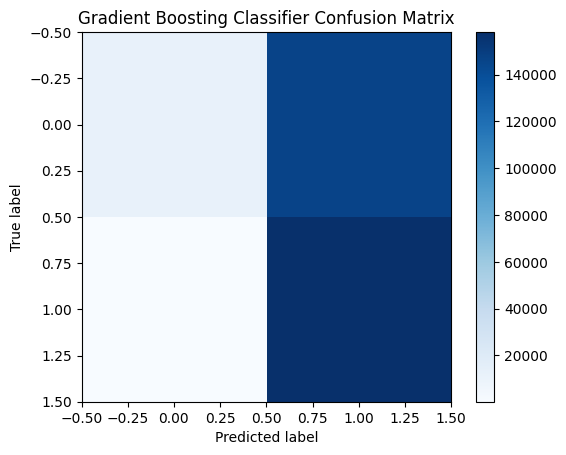

[[ 11365 146164]
 [   238 158162]]


In [43]:
plt.imshow(gbc_C.cm, cmap='Blues')
plt.colorbar()
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Gradient Boosting Classifier Confusion Matrix")
plt.show()
print(f"{gbc_C.cm}")

#### Plot of Logistic Regression Confusion Matrix

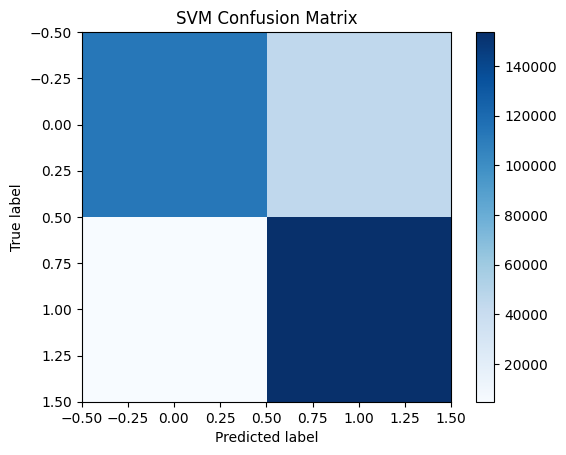

[[112874  44655]
 [  4818 153582]]


In [42]:
plt.imshow(svm_C.cm, cmap='Blues')
plt.colorbar()
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("SVM Confusion Matrix")
plt.show()
print(f"{svm_C.cm}")

#### Plot of Logistic Regression Confusion Matrix

In [7]:
plt.imshow(mnb_C.cm, cmap='Blues')
plt.colorbar()
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("MultinomialNB Confusion Matrix")
plt.show()
print(f"{mnb_C.cm}")

NameError: name 'mnb_C' is not defined

In [6]:
train_sizes, train_scores, test_scores = learning_curve(model, X_train, Y_train, cv=5, scoring="accuracy", train_sizes=np.linspace(0.1, 1.0, 10))
# Calculate the mean and standard deviation for the training scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)

# Calculate the mean and standard deviation for the test scores
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plot the learning curve
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
plt.legend(loc="best")

AttributeError: Can't get attribute 'PredictDisaster' on <module '__main__'>

#### Lets analyze the f1-score

In [51]:
#print the f1 scores
print(f"Logistic Regression f1 score: {lr_C.fs}\nGradient Boosting Classifier f1 score: {gbc_C.fs}\nSVM f1 score: {svm_C.fs}\nMultinomialNB f1 score: {mnb_C.fs}")

Logistic Regression f1 score: 0.9356690562844642
Gradient Boosting Classifier f1 score: 0.6836097388087119
SVM f1 score: 0.8612791157395335
MultinomialNB f1 score: 0.9471521870961802


In [52]:
def k_test(algo1_fs: float, algo2_fs: float, algo3_fs: float, algo4_fs: float) -> None:

    # Set up the hypotheses
    H0 = "There is no statistical significant difference between the f1-scores"
    H1 = "There are a statistical significant difference between the f1-scores"

    # Significance level
    alpha = 0.05

    t_stat, p_value = kruskal(algo1_fs, algo2_fs, algo3_fs, algo4_fs)

    # Check p_value against significance level(alpha)
    if p_value < alpha:
        print(f"{H1} -> p_value = {p_value}")

    else:
        print(f"{H0} -> p_value = {p_value}")
    
    
k_test(lr_C.fs, gbc_C.fs, svm_C.fs, mnb_C.fs)

There is no statistical significant difference between the f1-scores -> p_value = 0.3916251762710877
